In [5]:
import argparse
import glob
import os
import shutil
import sys
from PIL import Image
import numpy as np
import cv2

In [6]:
from metrics import calculate_metrics, draw_bounding_boxes_truth_pred

In [7]:
dict_name = {0 : 'bouchon_casse', 1 : 'trou', 2 : 'deforme', 3 : 'delamine'}

Save folder /home/psycle/PsycleResearch/Object-Detection-Metrics/results
Save folder /home/psycle/PsycleResearch/Object-Detection-Metrics/results
Save folder /home/psycle/PsycleResearch/Object-Detection-Metrics/results
AP: 100.00% (0)
AP: 60.00% (2)
AP: 50.00% (3)
mAP: 70.00%


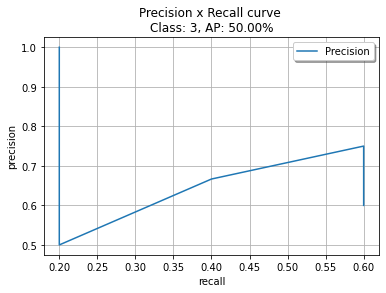

In [8]:
calculate_metrics(dict_name, gtFolder='/home/psycle/PsycleResearch/Object-Detection-Metrics/groundtruths', 
                  detFolder='/home/psycle/PsycleResearch/Object-Detection-Metrics/detections', iouThreshold=0.3, showPlot=False, gtCoordinates='rel', detCoordinates='rel',
                      imgSize='540,540', savePath='/home/psycle/PsycleResearch/Object-Detection-Metrics/results')

In [6]:
draw_bounding_boxes_truth_pred(dict_name, '/home/psycle/PsycleResearch/Object-Detection-Metrics/groundtruths',
                               '/home/psycle/PsycleResearch/Object-Detection-Metrics/groundtruths', 
                               '/home/psycle/PsycleResearch/Object-Detection-Metrics/results/images', 
                               '/home/psycle/PsycleResearch/Object-Detection-Metrics/detections')

In [2]:
################################################################################

In [2]:
# def get_label_name(index=None, return_dict=False):
#     dict_name = {
#         0: "perce",
#         1: "casse",
#         2: "deforme",
#         3: "corps_etranger_dans",
#         4: "corps_etranger_sur",
#         5: "produit_dans_cordon"}
#     if index == None:
#         print(dict_name)
#         if return_dict:
#             return dict_name
#     else:
#         return dict_name[index]
def get_label_name(index=None, return_dict=False):
    dict_name = {
        0: "bouchon_casse",
        1: "trou",
        2: "deforme",
        3: "delamine"}
        # 4: "corps_etranger_sur"}
        # 5: "produit_dans_cordon"}
    if index == None:
        print(dict_name)
        if return_dict:
            return dict_name
    else:
        return dict_name[index]

In [3]:
def convertToAbsoluteValues(size, box):
    # w_box = round(size[0] * box[2])
    # h_box = round(size[1] * box[3])
    xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
    xEnd = xIn + round(float(box[2]) * size[0])
    yEnd = yIn + round(float(box[3]) * size[1])
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
    return (xIn, yIn, xEnd, yEnd)

In [4]:
def add_bb_into_image(image, bb, color=(255, 0, 0), thickness=2, label=None):
    size = (image.shape[1], image.shape[0])
    x1, y1, x2, y2 = convertToAbsoluteValues(size, bb)
    r = int(color[0])
    g = int(color[1])
    b = int(color[2])
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    fontThickness = 1
    cv2.rectangle(image, (x1, y1), (x2, y2), (b, g, r), thickness)
    # Add label
    if label is not None:
        # Get size of the text box
        (tw, th) = cv2.getTextSize(label, font, fontScale, fontThickness)[0]
        # Top-left coord of the textbox
        (xin_bb, yin_bb) = (x1 + thickness, y1 - th + int(12.5 * fontScale))
        # Checking position of the text top-left (outside or inside the bb)
        if yin_bb - th <= 0:  # if outside the image
            yin_bb = y1 + th  # put it inside the bb
        r_Xin = x1 - int(thickness / 2)
        r_Yin = y1 - th - int(thickness / 2)
        # Draw filled rectangle to put the text in it
        cv2.rectangle(image, (r_Xin, r_Yin - thickness),
                      (r_Xin + tw + thickness * 3, r_Yin + th + int(12.5 * fontScale)), (b, g, r),
                      -1)
        cv2.putText(image, label, (xin_bb, yin_bb), font, fontScale, (0, 0, 0), fontThickness,
                    cv2.LINE_AA)
    return image

In [5]:
img_folder = 'groundtruths'
gt_annotations = 'groundtruths'
prediction_annotations = 'detections'
results = 'results'

In [6]:
def draw_boxes(annotations, img_folder, results, isGT=True):
    files = glob.glob(f"{annotations}/*.txt")
    #Extract bboxes
    for f in files:
        nameOfImage = f.replace(".txt", "").split('/')[1]
        if isGT:
            image = np.array(Image.open(f'{img_folder}/{nameOfImage}.jpg'))
        else:
            image = np.array(Image.open(f'{results}/{nameOfImage}.jpg'))
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n", "")
            if line.replace(' ', '') == '':
                continue
            splitLine = line.split(" ")
            if isGT:
                # idClass = int(splitLine[0]) #class
                idClass = (splitLine[0])  # class
                x = float(splitLine[1])
                y = float(splitLine[2])
                w = float(splitLine[3])
                h = float(splitLine[4])
                img = add_bb_into_image(image, [x,y,w,h], 
                    color=(255, 0, 0), thickness=2, label=get_label_name(int(idClass),return_dict=None))
            else:
                idClass = (splitLine[0])  # class
                confidence = float(splitLine[1])
                x = float(splitLine[2])
                y = float(splitLine[3])
                w = float(splitLine[4])
                h = float(splitLine[5])
                img = add_bb_into_image(image, [x,y,w,h], color=(0, 0, 255), thickness=2, 
                                        label=get_label_name(int(idClass),return_dict=None))
        Image.fromarray(img).save(f'{results}/{nameOfImage}.jpg')
        fh1.close()

In [7]:
draw_boxes(gt_annotations, img_folder, results, isGT=True)
draw_boxes(prediction_annotations, img_folder, results, isGT=False)

In [8]:
def add_legend(results):
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 1
    color_pred = (255, 0, 0)
    color_truth = (0, 0, 255) 
    thickness = 2
    images = glob.glob(f"{results}/*.jpg")
    for image_path in images:
        image = np.array(Image.open(image_path))
        org_truth = (image.shape[1]-200, 100)
        org_pred = (image.shape[1]-200, 150)
        cv2.putText(image, 'Pred', org_pred, font,  
                   fontScale, color_pred, thickness, cv2.LINE_AA) 
        cv2.putText(image, 'Verite', org_truth, font,  
                   fontScale, color_truth, thickness, cv2.LINE_AA) 
        Image.fromarray(image).save(image_path)

In [9]:
add_legend(results)